In [19]:
# This file is associated with the book
# "Machine Learning Refined", Cambridge University Press, 2016.
# by Jeremy Watt, Reza Borhani, and Aggelos Katsaggelos.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

A simple data loading function.

In [20]:
# import training data 
def load_data(csvname):
    # load in data
    data = np.asarray(pd.read_csv(csvname))

    # import data and reshape appropriately
    X = data[:,0:-1]
    y = data[:,-1]
    y.shape = (len(y),1)
    
    # pad data with ones for more compact gradient computation
    o = np.ones((np.shape(X)[0],1))
    X = np.concatenate((o,X),axis = 1)
    X = X.T
    
    return X,y

Our one versus all main loop - where we loop through each two-class subproblem and learn its respective weights.

In [21]:
# learn all C separators
def learn_separators(X,y):
    W = []
    num_classes = np.size(np.unique(y))
    for i in range(0,num_classes):
        # prepare temporary C vs notC probem labels
        y_temp = np.copy(y)
        ind = np.argwhere(y_temp == (i+1))
        ind = ind[:,0]
        ind2 = np.argwhere(y_temp != (i+1))
        ind2 = ind2[:,0]
        y_temp[ind] = 1
        y_temp[ind2] = -1
        
        # run descent algorithm to classify C vs notC problem
        w0 = np.random.randn(np.shape(X)[0],1)
        w = softmax_newtons_method(X,y_temp,w0)
        W.append(w)
    W = np.asarray(W)
    W.shape = (np.shape(W)[0],np.shape(W)[1])
    W = W.T
    return W

Up next - functionality for running Newton's method on the softmax cost function.

In [22]:
# function for computing gradient and Hessian for Newton's method
def softmax_grad_hess(X,y,w):
    hess = 0
    grad = 0
    for p in range(0,len(y)):
        # precompute
        x_p = X[:,p]
        y_p = y[p]
        s = 1/(1 + my_exp(y_p*np.dot(x_p.T,w)))
        g = s*(1-s)
        
        # update grad and hessian
        grad+= -s*y_p*x_p
        hess+= np.outer(x_p,x_p)*g
        
    grad.shape = (len(grad),1)
    return grad,hess

# run newton's method
def softmax_newtons_method(X,y,w):
    # begin newton's method loop
    max_its = 20
    
    for k in range(max_its):
        # compute gradient and Hessian
        grad,hess = softmax_grad_hess(X,y,w)
        
        # take Newton step
        temp = np.dot(hess,w) - grad
        w = np.dot(np.linalg.pinv(hess),temp)
    return w

# avoid overflow when using exp - just cutoff after arguments get too large/small
def my_exp(u):
    s = np.argwhere(u > 100)
    t = np.argwhere(u < -100)
    u[s] = 0
    u[t] = 0
    u = np.exp(u)
    u[t] = 1
    return u

# function for counting the number of misclassifications
def count_misclasses(X,y,w):
    y_pred = np.sign(np.dot(X.T,w))
    num_misclassed = len(y) - len([i for i, j in zip(y, y_pred) if i == j])
    return num_misclassed

Plotting functinos to show the dataset and multiclass separator learned to the data.

In [23]:
# plotting function for the data and individual separators
def plot_data_and_subproblem_separators(X,y,W):
    # initialize figure, plot data, and dress up panels with axes labels etc.
    num_classes = np.size(np.unique(y))
    color_opts = np.array([[1,0,0.4], [ 0, 0.4, 1],[0, 1, 0.5],[1, 0.7, 0.5],[0.7, 0.6, 0.5]])
    f,axs = plt.subplots(1,num_classes + 1,facecolor = 'white',figsize = (10,2))

    r = np.linspace(0,1,150)
    for a in range(0,num_classes):
        # color current class
        axs[a].scatter(X[1,],X[2,], s = 30,color = '0.75')
        s = np.argwhere(y == a+1)
        s = s[:,0]
        axs[a].scatter(X[1,s],X[2,s], s = 30,color = color_opts[a,:])
        axs[num_classes].scatter(X[1,s],X[2,s], s = 30,color = color_opts[a,:])

        # draw subproblem separator
        z = -W[0,a]/W[2,a] - W[1,a]/W[2,a]*r
        axs[a].plot(r,z,'-k',linewidth = 2,color = color_opts[a,:])

        # dress panel correctly
        axs[a].set_xlim(0,1)
        axs[a].set_ylim(0,1)
        axs[a].axis('off')
    axs[num_classes].axis('off')

    return axs

# fuse individual subproblem separators into one joint rule
def plot_joint_separator(W,axs,num_classes):
    r = np.linspace(0,1,300)
    s,t = np.meshgrid(r,r)
    s = np.reshape(s,(np.size(s),1))
    t = np.reshape(t,(np.size(t),1))
    h = np.concatenate((np.ones((np.size(s),1)),s,t),1)
    f = np.dot(W.T,h.T)
    z = np.argmax(f,0)
    f.shape = (np.size(f),1)
    s.shape = (np.size(r),np.size(r))
    t.shape = (np.size(r),np.size(r))
    z.shape = (np.size(r),np.size(r))

    for i in range(0,num_classes + 1):
        axs[num_classes].contour(s,t,z,num_classes-1,colors = 'k',linewidths = 2.25)

With everything defined lets run all.

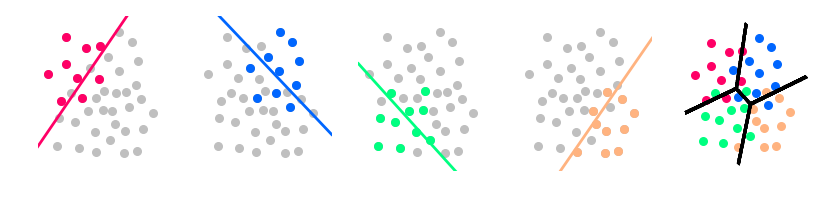

In [24]:
# load the data
X,y = load_data('four_class_data.csv')

# learn all C vs notC separators
W = learn_separators(X,y)

# plot data and each subproblem 2-class separator
axs = plot_data_and_subproblem_separators(X,y,W)

# plot fused separator
plot_joint_separator(W,axs,np.size(np.unique(y)))

plt.show()